# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 120

In [2]:
sc.__version__

'1.9.1'

In [3]:
import rmm
rmm.reinitialize(
    managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/500000.h5ad")

CPU times: user 535 ms, sys: 5.69 s, total: 6.22 s
Wall time: 30.4 s


In [6]:
adata.shape

(500000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(500000, 27998)

And the number of non-zero values in the matrix:

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 30.471596717834473


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('mt-') 

CPU times: user 5.33 ms, sys: 0 ns, total: 5.33 ms
Wall time: 5.2 ms


In [11]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

CPU times: user 11.2 s, sys: 557 ms, total: 11.8 s
Wall time: 11.8 s


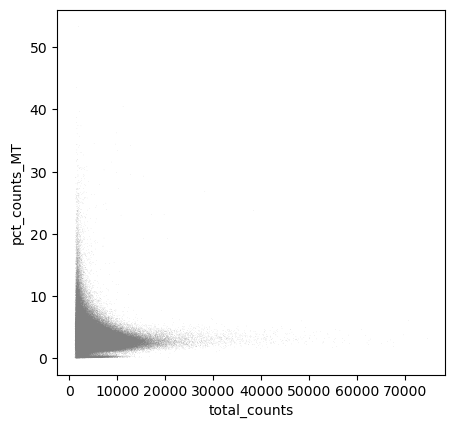

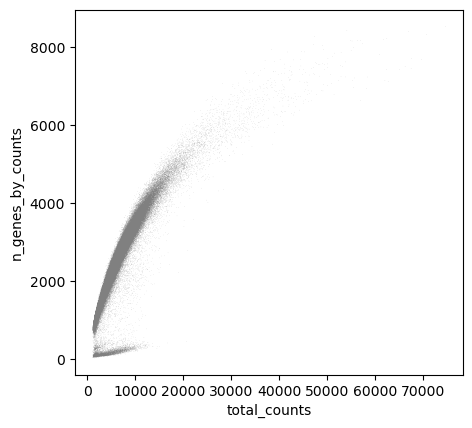

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

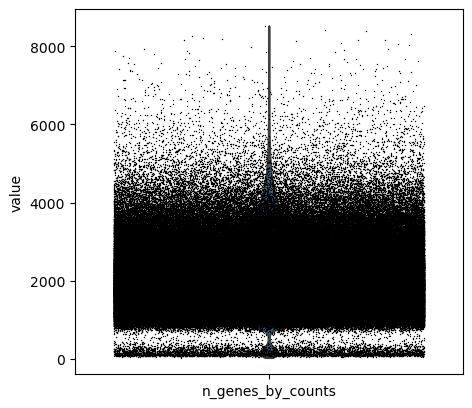

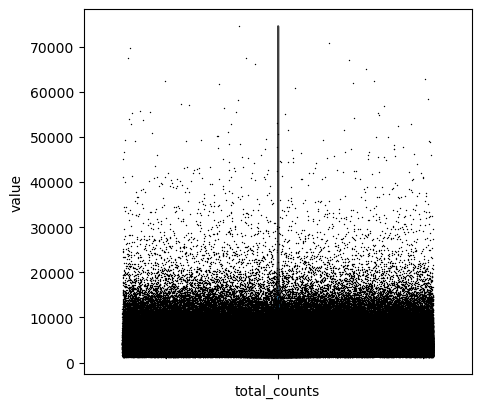

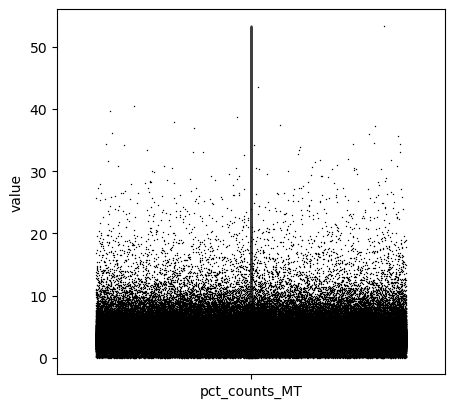

In [13]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4)
sc.pl.violin(adata, 'total_counts',jitter=0.4)
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4)


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["n_genes_by_counts"] > 500]

adata.shape

CPU times: user 18 ms, sys: 16.8 ms, total: 34.7 ms
Wall time: 22.3 ms


(492660, 27998)

In [15]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 9.17 ms, sys: 339 µs, total: 9.51 ms
Wall time: 9.15 ms


(492376, 27998)

We also filter out genes that are expressed in less than 3 cells.

In [16]:
%%time
sc.pp.filter_genes(adata,min_cells=3)

/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


CPU times: user 27.6 s, sys: 3.52 s, total: 31.1 s
Wall time: 31.3 s


In [17]:
adata.layers["counts"] = adata.X.copy()

In [18]:
adata.shape

(492376, 21803)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 2.27 s, sys: 300 ms, total: 2.57 s
Wall time: 2.58 s


Next, we log transform the count matrix.

In [20]:
%%time
sc.pp.log1p(adata)

CPU times: user 8.48 s, sys: 325 µs, total: 8.48 s
Wall time: 8.51 s


### Select Most Variable Genes

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [21]:
%%time
sc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="seurat_v3",layer = "counts")

CPU times: user 37.6 s, sys: 7.41 s, total: 45 s
Wall time: 41.4 s


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [22]:
%%time
adata.raw = adata

CPU times: user 448 ms, sys: 302 ms, total: 750 ms
Wall time: 752 ms


Now we restrict our cunndata object to the highly variable genes.

In [23]:
%%time
adata = adata[:,adata.var["highly_variable"]==True]

CPU times: user 467 ms, sys: 460 ms, total: 926 ms
Wall time: 930 ms


In [24]:
adata.shape

(492376, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [25]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 1min 8s, sys: 58.3 s, total: 2min 7s
Wall time: 10min 24s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [26]:
%%time
sc.pp.scale(adata,max_value=10)

CPU times: user 7.52 s, sys: 846 ms, total: 8.37 s
Wall time: 8.4 s


### Principal component analysis

In [27]:
%%time
sc.pp.pca(adata, n_comps = 100)

CPU times: user 2h 52min 6s, sys: 59min 4s, total: 3h 51min 11s
Wall time: 2min 31s


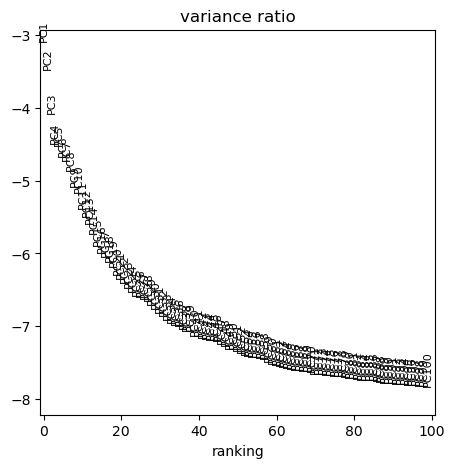

In [28]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

In [29]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 890.0894017219543


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

In [30]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=60)

CPU times: user 8min 31s, sys: 27min 22s, total: 35min 54s
Wall time: 1min 14s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [31]:
%%time
sc.tl.umap(adata)

CPU times: user 2h 35min 45s, sys: 1h 33min 42s, total: 4h 9min 28s
Wall time: 6min 43s


### Clustering

In [32]:
%%time
sc.tl.louvain(adata, resolution=0.6)


CPU times: user 2min 2s, sys: 640 ms, total: 2min 3s
Wall time: 2min 3s


In [33]:
%%time
sc.tl.leiden(adata,resolution=0.6)

CPU times: user 5min 27s, sys: 3.66 s, total: 5min 31s
Wall time: 5min 32s


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


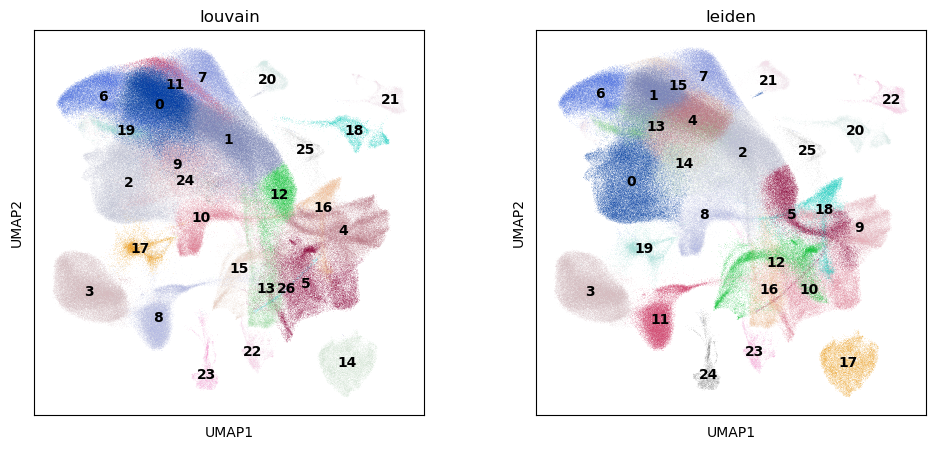

CPU times: user 2.97 s, sys: 226 ms, total: 3.2 s
Wall time: 3.03 s


In [34]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

## TSNE

In [35]:
%%time
sc.tl.tsne(adata, n_pcs = 40)

/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(


CPU times: user 12h 10min 28s, sys: 7min 4s, total: 12h 17min 32s
Wall time: 17min 39s


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


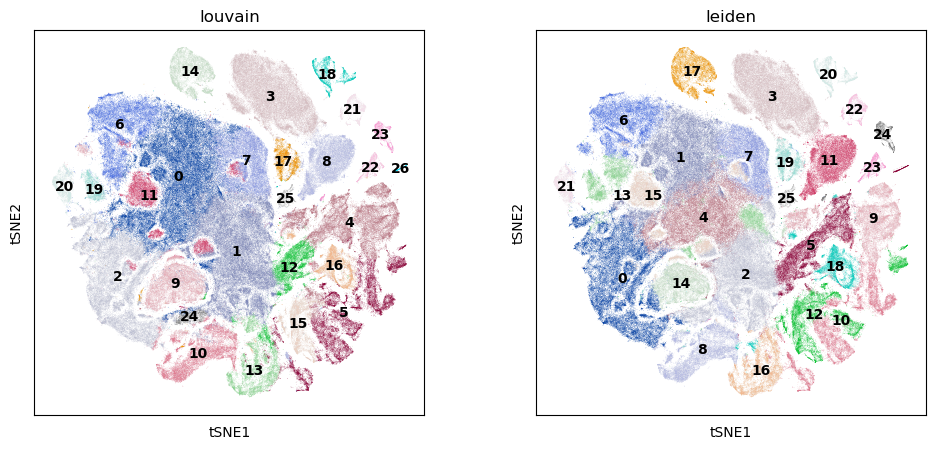

In [36]:
sc.pl.tsne(adata,color=["louvain","leiden"], legend_loc='on data')

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Leidencluster.

In [37]:
%%time
sc.tl.rank_genes_groups(adata, groupby="leiden", method='logreg',layer="counts", use_raw=False)

CPU times: user 13min 5s, sys: 29min 39s, total: 42min 45s
Wall time: 7min 32s


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


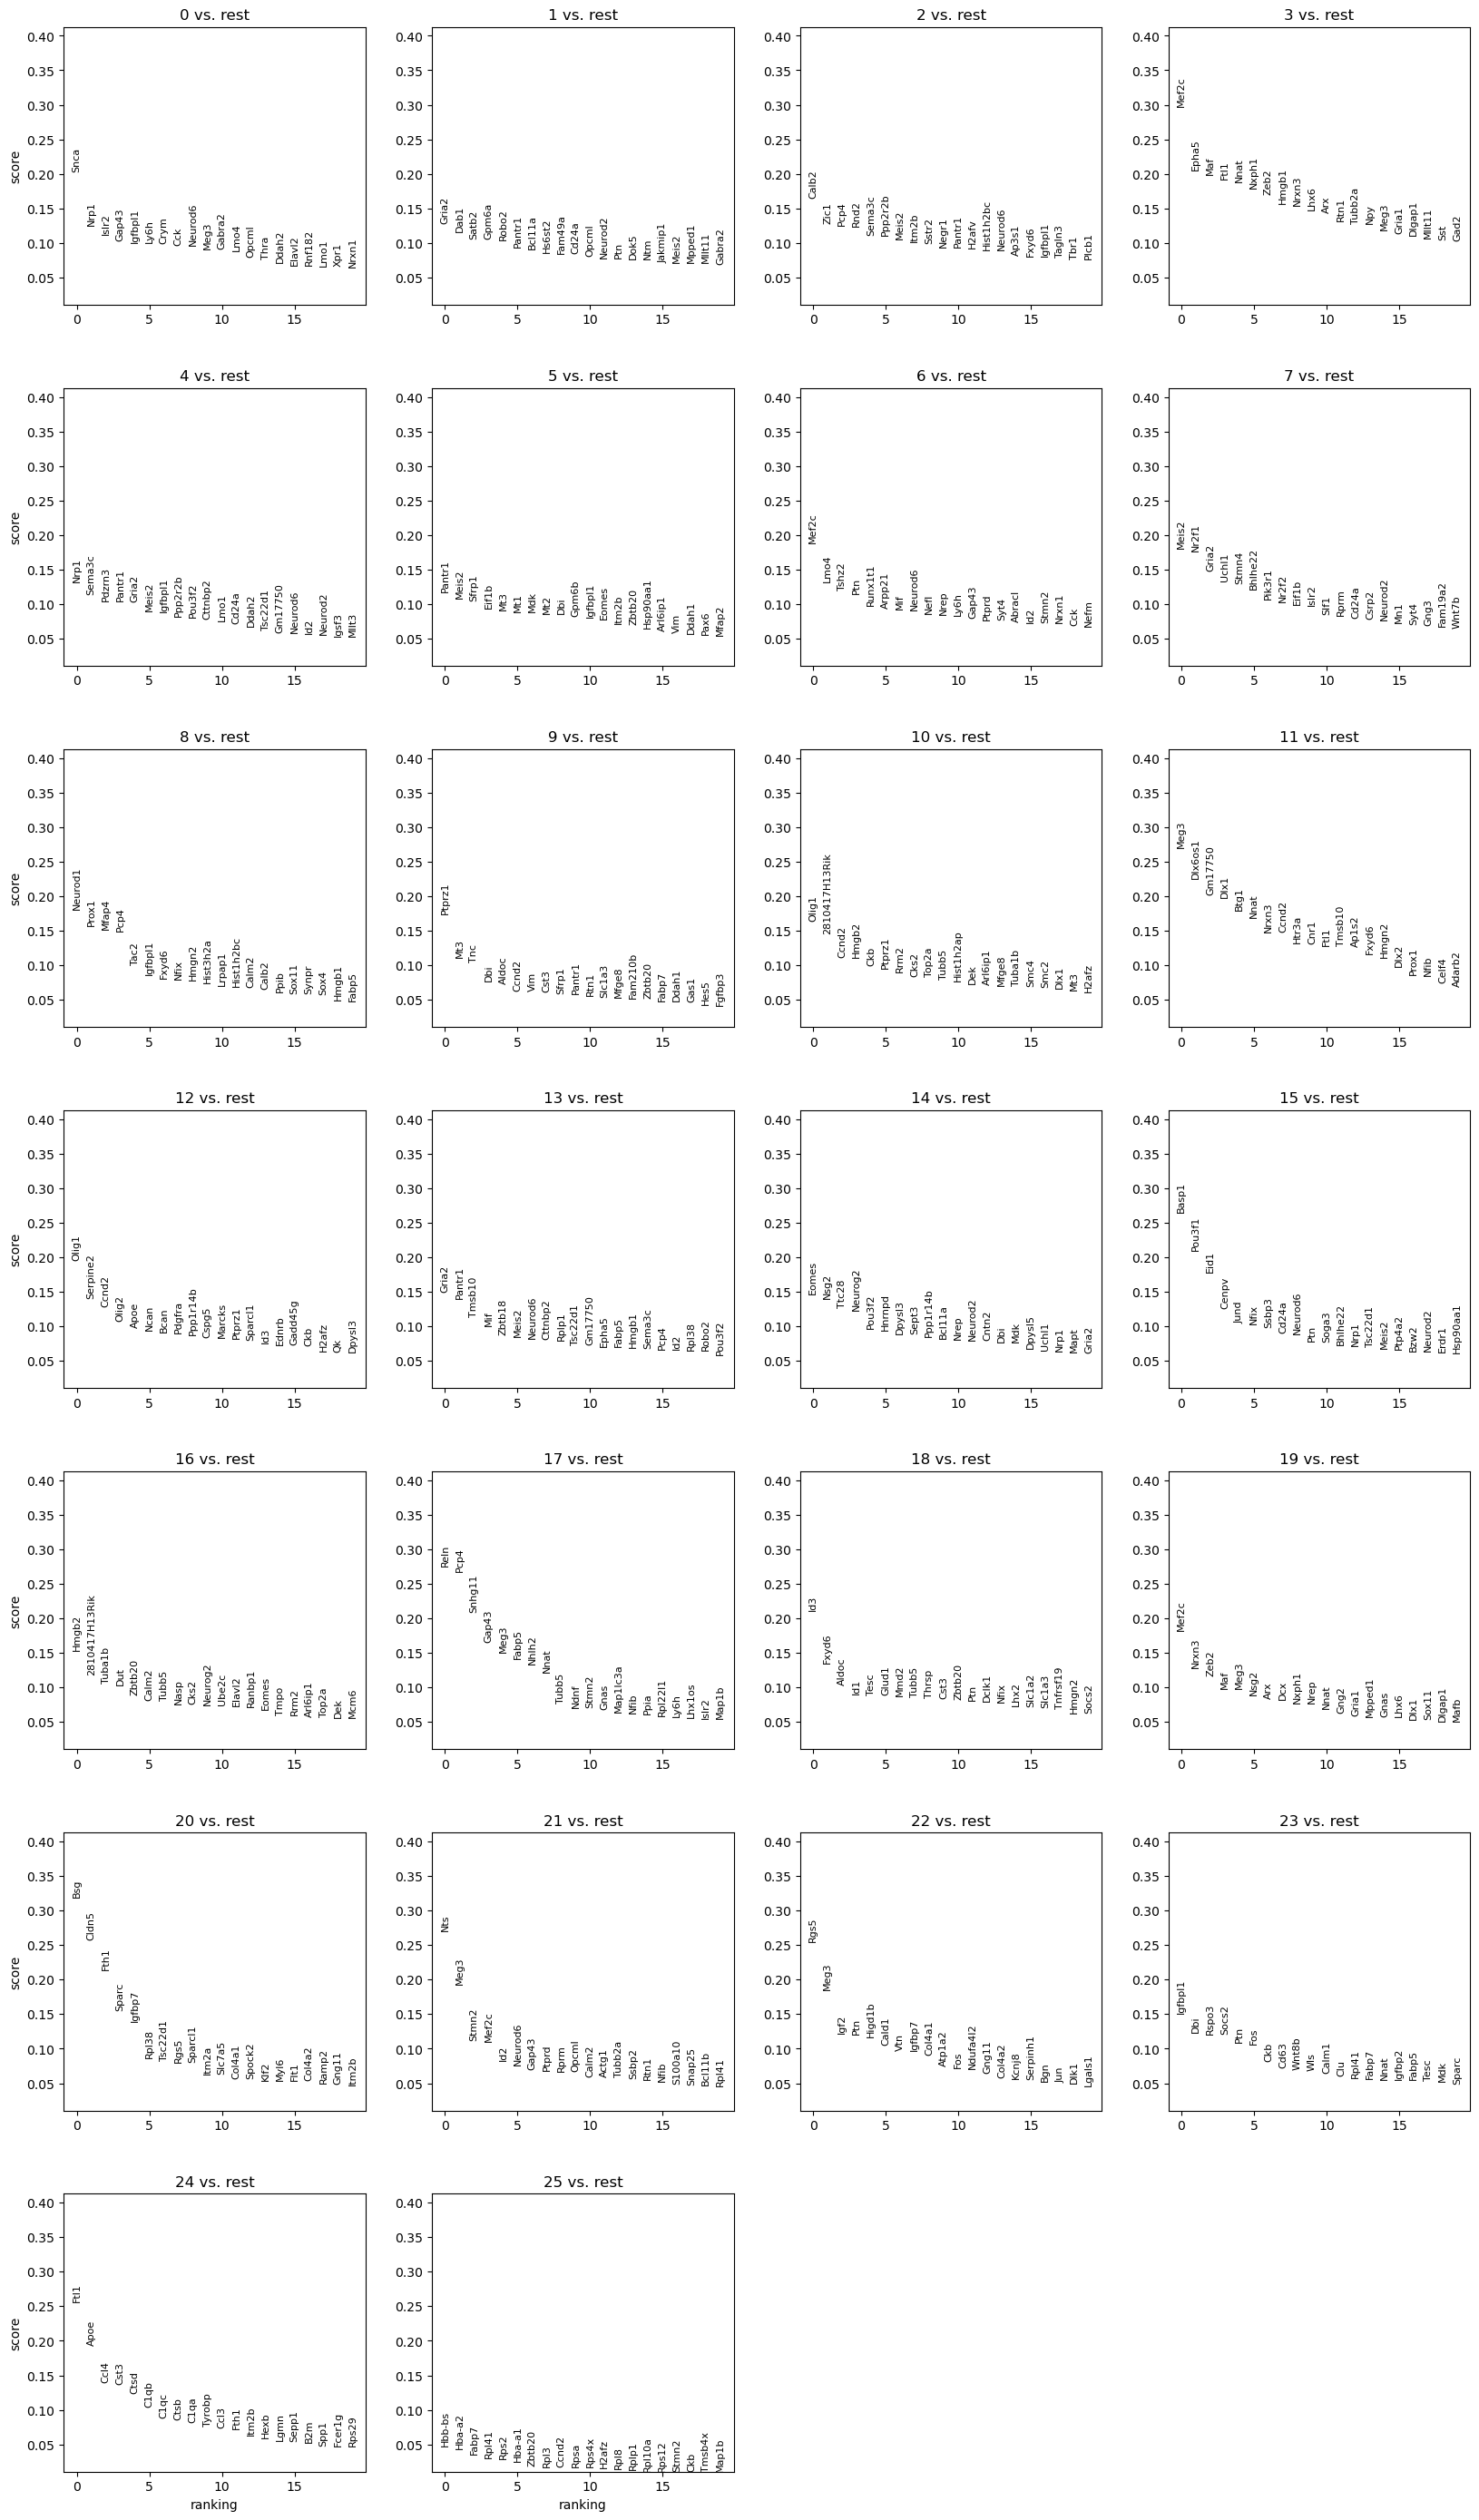

CPU times: user 2.14 s, sys: 187 ms, total: 2.33 s
Wall time: 2.16 s


In [38]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [39]:
post_time = time.time()

In [40]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 2453.282457590103


## Diffusion Maps

In [41]:
%%time
sc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:] 

CPU times: user 11min 47s, sys: 48min 21s, total: 1h 8s
Wall time: 37 s


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


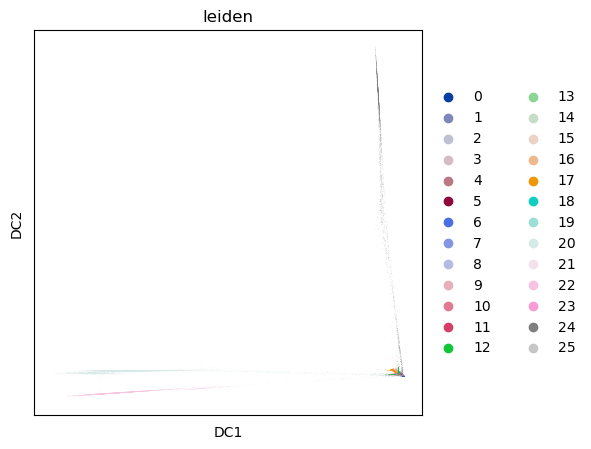

In [42]:
sc.pl.diffmap(adata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [43]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 3382.1178755760193
